In [1]:
# standards
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 3rd party packages
import qiskit as qk
import networkx as nx
import tenpy

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits

## HoloPy demo: XXZ-chain
$$H=\sum_{i=1}^{L-1} \sigma^x_{i}\sigma^x_{i+1}+\sigma^y_{i}\sigma^y_{i+1} + \Delta \sigma^z_i\sigma^z_{i+1}$$

In [6]:
## Define model parameters ## 
Delta = 1.5 # Ising anisotropy 
nb = 2 # number of bond-qubits 

# ansatz parameters
L = 1 # number of unit cells
l_uc = 1 # number of sites in unit cell

In [8]:
## Setup IsoMPS ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Initialize parameterized circuits
# bond-prep circuit (sets left-boundary vector of MPS)
bond_prep_circ = QKParamCircuit(qk.QuantumCircuit(breg),[])
pcircs = [bond_prep_circ]

# circuits that generate tensors
params = [] # list of circuit parameters
for j in range(l_uc):
    circ_tmp,params_tmp = circuits.star_circ(preg,
                                             breg,
                                             label='[c{}]'.format(j),
                                             circ_type='xxz') 
    pcircs+=[circ_tmp]
    params+=params_tmp

# setup circuit-generated isoMPS
psi_mps = IsoMPS(preg,breg,pcircs,L=L,basis='zzzzzz')

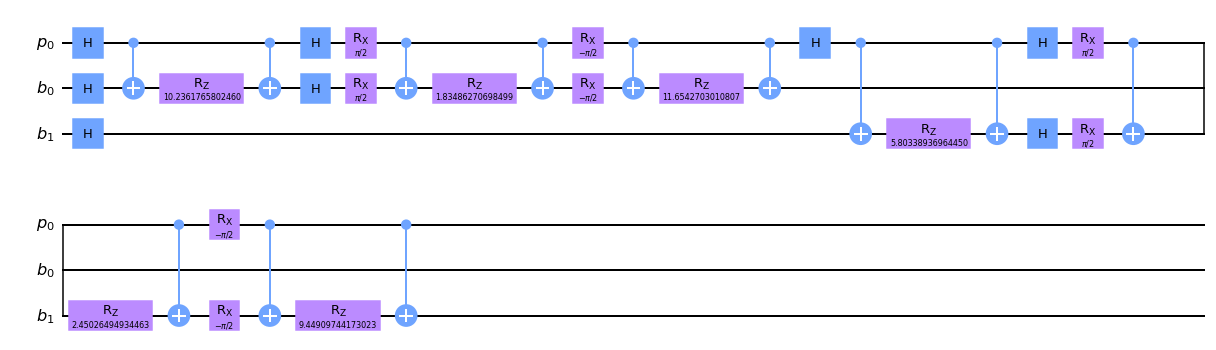

In [10]:
## Example (resolve parameters => random values and print circuit)
# pick some random parameter values
param_vals = [4*np.pi*np.random.rand() for j in range(len(params))]
param_dict = dict(zip(params,param_vals))
psi_mps.construct_circuit(param_dict,include_measurements=False)
psi_mps.circ.draw('mpl')

## 1. Compute energy by exporting to tenpy

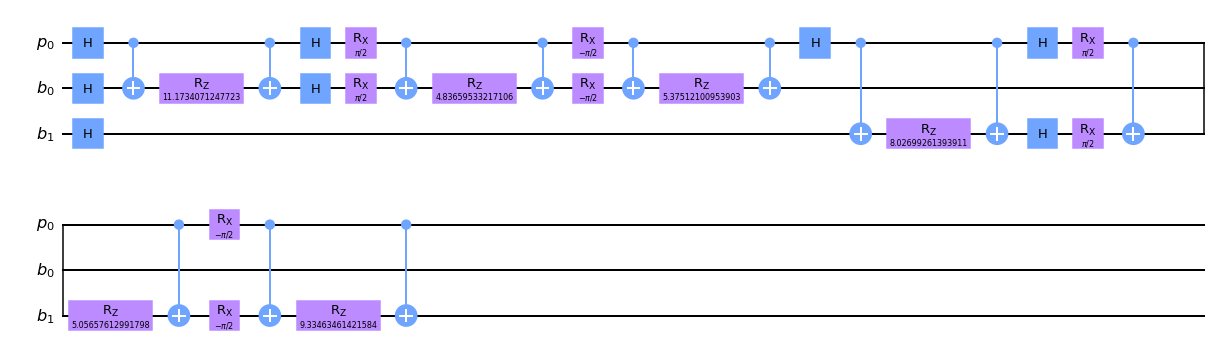

In [9]:
## Setup Tenpy Model ## ho